In [1]:
import jax
import jax.numpy as jnp
import sys
sys.path.append('..')
from networks import *
from utils import *

In [2]:
import matplotlib.pyplot as plt
import scienceplots
import cmasher as cmr
plt.style.use('science')
cmap_pred = plt.get_cmap('cmr.bubblegum')
cmap_error = plt.get_cmap('cmr.cosmic')
from quadax import simpson

In [3]:
problem = "advection"
running_on = "local"
if running_on == "local":
    data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
    checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"
else:
    data_path = "/cluster/work/eirikaf/data/"
    checkpoint_path = "/cluster/work/eirikaf/checkpoints/"

In [4]:
data = jnp.load(data_path + problem + ".npz")
train_val_test = train_val_test_split(data["data"], 0.8, 0.1, 0.1)
u_test = train_val_test["test"]
scaled_data = jnp.load(data_path + problem + "_z_score.npz")

In [5]:
t_test = data["t"]
x_test = data["x"]

In [6]:
a_train_s = scaled_data["a_train_s"]
u_train_s = scaled_data["u_train_s"]
a_val_s = scaled_data["a_val_s"]
u_val_s = scaled_data["u_val_s"]
a_test_s = scaled_data["a_test_s"]
u_test_s = scaled_data["u_test_s"]

x_train_s = scaled_data["x_train_s"]
t_train_s = scaled_data["t_train_s"]

x_test_s = scaled_data["x_test_s"] 
t_test_s = scaled_data["t_test_s"]

In [7]:
u_std = scaled_data["u_std"]
u_mean = scaled_data["u_mean"]
x_std = scaled_data["x_std"]
x_mean = scaled_data["x_mean"]
t_std = scaled_data["t_std"]
t_mean = scaled_data["t_mean"]

x_encoder = lambda x: (x - x_mean) / x_std
x_decoder = lambda x: x * x_std + x_mean
t_encoder = lambda t: (t - t_mean) / t_std
t_decoder = lambda t: t * t_std + t_mean
u_encoder = lambda u: (u - u_mean) / u_std
u_decoder = lambda u: u * u_std + u_mean

In [16]:
from traditional_solvers import Dx

def sech(x): return 1/jnp.cosh(x)

def u_soliton(x, t, P=20, c = 1, d = 0.5):        
    return 2 * c**2 * sech(c * ((x-c*t+P/2-P*d) % P - P/2))**2

key_c, key_d = random.split(random.key(190000))
c = random.uniform(key_c, minval=0.5, maxval=1.5, shape=())
d = random.uniform(key_d, minval=0, maxval=1, shape=())

u_test_sample = vmap(lambda t : u_soliton(x_test, t, P=20, c=c, d=d))(t_test)
a_test_sample = u_test_sample[0]

u_test_sample_s = u_encoder(u_test_sample)
a_test_sample_s = u_encoder(a_test_sample)

def F(u):
    return c/2*u**2

def H(u, dx):
    return dx*jnp.sum(F(u), axis=1)

In [9]:
from networks.hno_fno1d import HNO as FNO1d_HNO
from networks.hno_deeponet import HNO as DeepONet_HNO
from networks.hno_fno2d import HNO as FNO2d_HNO
from networks.hno_fno_timestepping import HNO as FNOTS_HNO
from networks.hno_modified_deeponet import HNO as Modified_DeepONet_HNO

In [10]:
vanilla_networks = {
    "deeponet": DeepONet,
    "modified_deeponet": ModifiedDeepONet,
    "fno_timestepping": FNOTimeStepping,
    "fno1d": FNO1d,
    "fno2d": FNO2d,
}

hon_networks = {
    "deeponet": DeepONet_HNO,
    "modified_deeponet": Modified_DeepONet_HNO,
    "fno_timestepping": FNOTS_HNO,
    "fno1d": FNO1d_HNO,
    "fno2d": FNO2d_HNO,
}

pretty_names = {
    "deeponet": "DeepONet",
    "modified_deeponet": "ModifiedDeepONet",
    "fno_timestepping": "FNOTimeStepping",
    "fno1d": "FNO1d",
    "fno2d": "FNO2d"
}

hon_models = {}
vanilla_models = {}
hon_trainers = {}
vanilla_trainers = {}

for network_name in vanilla_networks.keys():
    print(network_name)
    try:
        vanilla_trainers[network_name] = Trainer.from_checkpoint(checkpoint_path + f"{network_name}_{problem}", 
                                                    vanilla_networks[network_name])
        vanilla_models[network_name] = vanilla_trainers[network_name].model
        
    except:
        print("No checkpoint found for", network_name)
        continue
    
    

for network_name in hon_networks.keys():
    print(network_name)
    try:
        hon_trainers[network_name] = Trainer.from_checkpoint(checkpoint_path + f"{network_name}_HON_{problem}", 
                                                    hon_networks[network_name])
        hon_models[network_name] = hon_trainers[network_name].model
        
    except:
        print("No checkpoint found for", network_name)
        continue

deeponet
modified_deeponet
fno_timestepping
fno1d
fno2d
deeponet
modified_deeponet
fno_timestepping
fno1d
fno2d


### Plot one prediction from the test set for t = 0, t $\approx$ 1, t $\approx$ 2, t $\approx$ 3

In [11]:
u_preds_soft_constraint = {}
u_preds_hard_constraint = {}
u_preds_vanilla = {}
for network_name, model in hon_models.items():
    """
    To extrapolate, we use the solution at t~2 as the initial condition for the next time interval [~2, 4).
    """
    t = t_test_s[t_test < 2] # time interval [0, 2)

    # prediction on [0, 2)
    u_pred1_soft = model.u.predict_whole_grid(a_test_sample_s, x_test_s, t)
    u_pred1_hard = model.u_integrated_gauss(a_test_sample_s, x_test_s, t)
    
    # prediction on [~2, 4) by using the last prediction (at t~2) as initial condition
    u_pred2_soft = model.u.predict_whole_grid(u_pred1_soft[-1], x_test_s, t)
    u_pred2_hard = model.u_integrated_gauss(model.u.encode_u(u_pred1_hard[-1]), x_test_s, t)
    
    # concatenate the predictions on [0, 2) and [~2, 4), making sure not to include the overlapping time point twice
    u_preds_soft_constraint[network_name] = model.u.decode_u(jnp.concatenate((u_pred1_soft, u_pred2_soft[1:]), axis=0))[:len(t_test)]
    u_preds_hard_constraint[network_name] = jnp.concatenate((u_pred1_hard, u_pred2_hard[1:]), axis=0)[:len(t_test)]

In [12]:
for network_name, model in vanilla_models.items():
    """
    To extrapolate, we use the solution at t~2 as the initial condition for the next time interval [~2, 4).
    """
    t = t_test_s[t_test < 2] # time interval [0, 2)

    u_pred1_vanilla = model.predict_whole_grid(a_test_sample_s, x_test_s, t)
    u_pred2_vanilla = model.predict_whole_grid(u_pred1_vanilla[-1], x_test_s, t)
    u_preds_vanilla[network_name] = model.decode_u(jnp.concatenate((u_pred1_vanilla, u_pred2_vanilla[1:]), axis=0))[:len(t_test)]

In [13]:
u_gt = u_test_sample
u_gt_x = Dx(u_gt, x_test[1], axis=1)

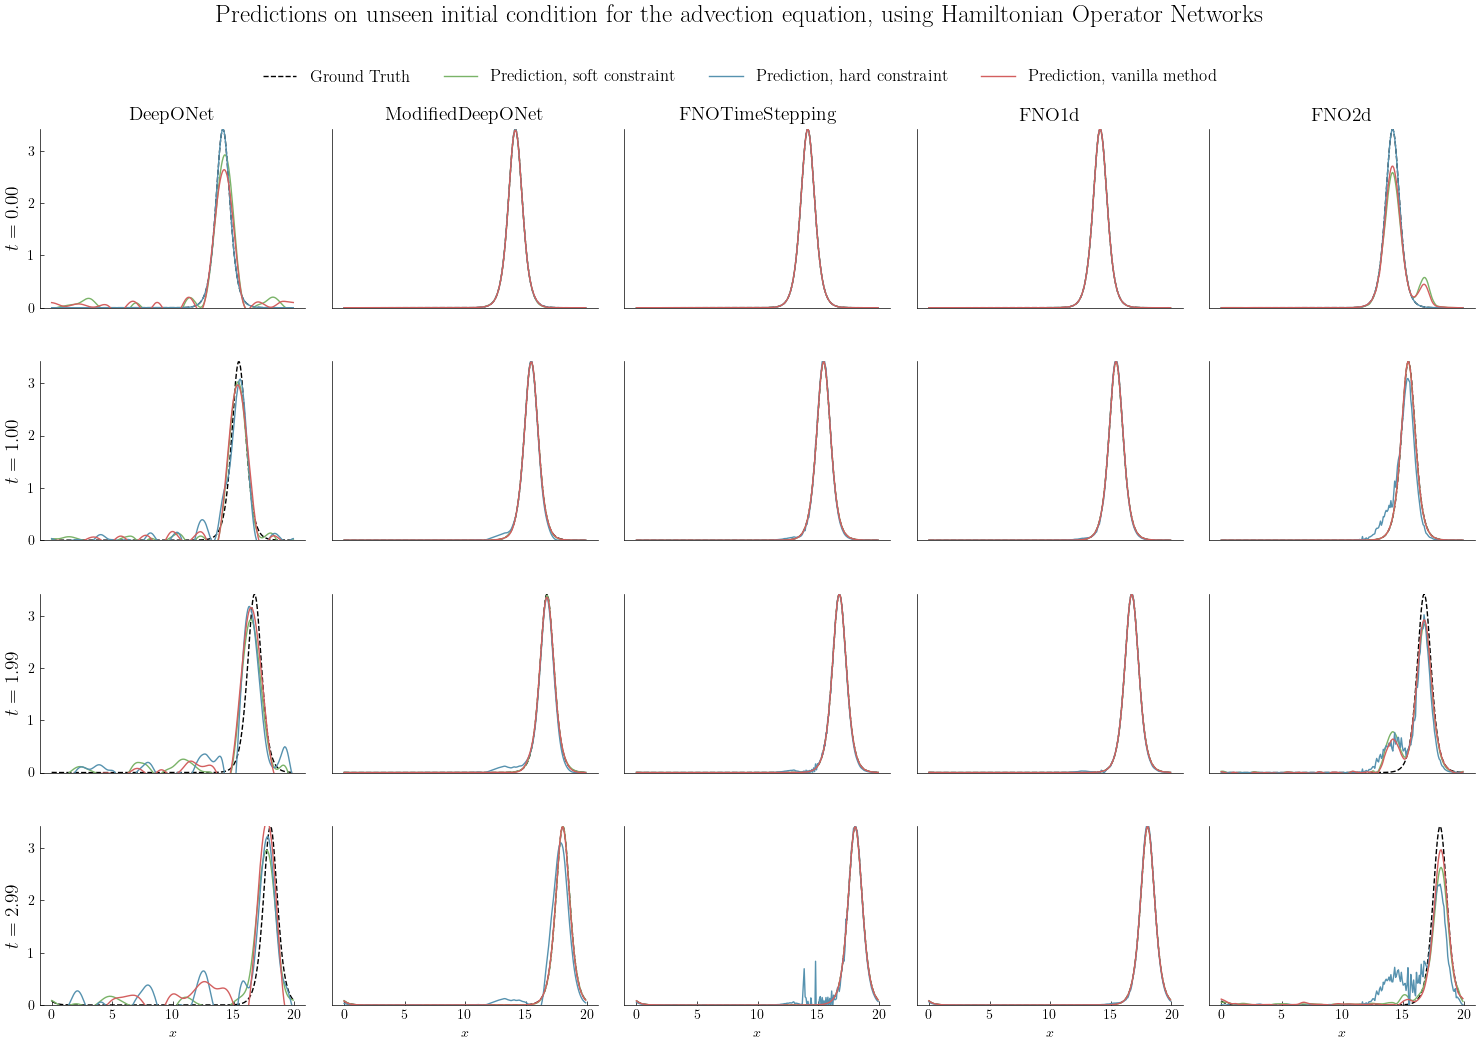

In [14]:
pred_color_soft = "#7ab368"
pred_color_hard = "#5692af"
pred_color_vanilla = "#d35f5f"


time_indices = [0, jnp.where(t_test == 1)[0][0], jnp.where(t_test < 2)[0][-1], -1]
time_labels = [rf'$t={t_test[time_indices[0]]:.2f}$', rf'$t={t_test[time_indices[1]]:.2f}$', rf'$t={t_test[time_indices[2]]:.2f}$', rf'$t={t_test[time_indices[3]]:.2f}$']

fig, axes = plt.subplots(len(time_indices), len(u_preds_soft_constraint), figsize=(15, 10))

y_min, y_max = u_gt.min(), u_gt.max()
for i, time_idx in enumerate(time_indices):
    for j, model_name in enumerate(pretty_names.keys()):
        u_pred_soft = u_preds_soft_constraint[model_name]
        u_pred_hard = u_preds_hard_constraint[model_name]
        u_pred_vanilla = u_preds_vanilla[model_name]
        ax = axes[i, j]
        ax.plot(x_test, u_gt[time_idx, :], 'k--', label='Ground Truth')
        ax.plot(x_test, u_pred_soft[time_idx, :], color=pred_color_soft, label='Prediction, soft constraint')
        ax.plot(x_test, u_pred_hard[time_idx, :], color=pred_color_hard, label='Prediction, hard constraint')
        ax.plot(x_test, u_pred_vanilla[time_idx, :], color=pred_color_vanilla, label='Prediction, vanilla method')
        ax.set_ylim(y_min, y_max)  # Set the y-axis limits
        
        ax.tick_params(top=False,
                left=False,
                right=False, 
                bottom=False, 
                labelleft=False, 
                labelbottom=False, 
                which='both')
                
        if i == 0:
            ax.set_title(pretty_names[model_name], fontsize=14)
        if j == 0:
            ax.set_ylabel(time_labels[i], fontsize=14)
            ax.tick_params(left=True, labelleft=True)
        if i == len(time_indices) - 1:
            ax.set_xlabel(r'$x$')
            ax.tick_params(bottom=True, labelbottom=True)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.), fontsize='large')

# Add a title to the figure
fig.suptitle('Predictions on unseen initial condition for the advection equation, using Hamiltonian Operator Networks', fontsize=18, x=0.5, y=1.05)

# Adjust space between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.3)

plt.savefig("predictions/pred_hon_adv.svg")
plt.show()

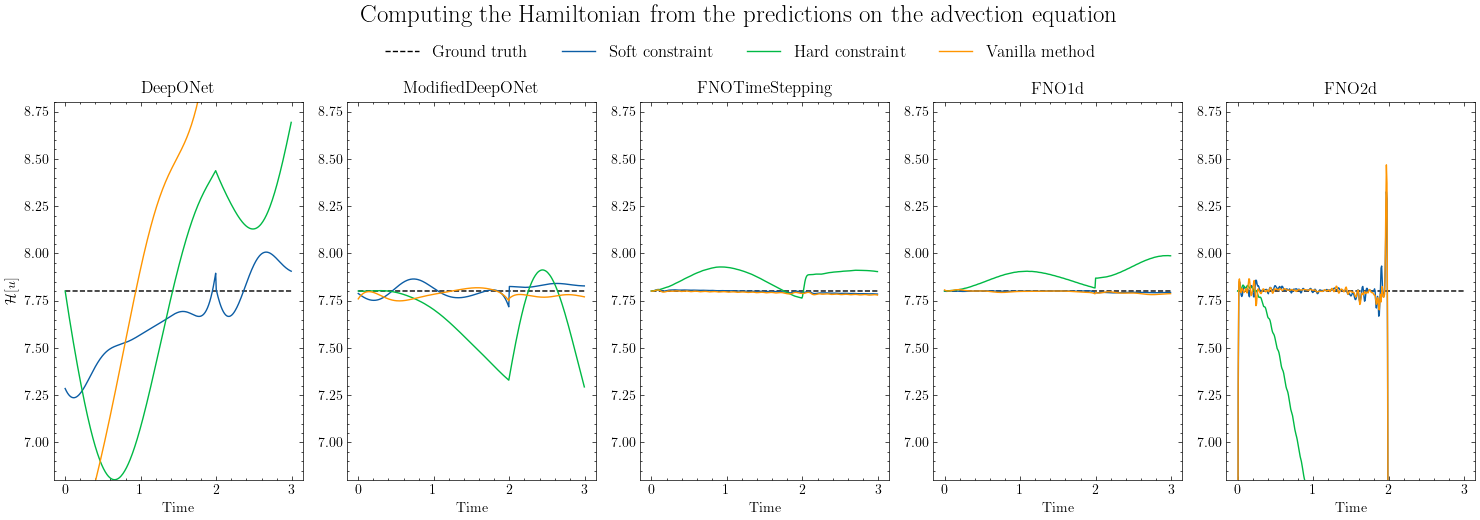

In [22]:
fig, axes = plt.subplots(1, len(hon_models), figsize=(15, 5))
fig.suptitle('Computing the Hamiltonian from the predictions on the advection equation', fontsize=18, x=0.5, y=1.05)

H_gt = H(u_gt, x_test[1])
y_min, y_max = H_gt.min()-1, H_gt.max()+1

for i, (model_name, model) in enumerate(hon_models.items()):
    ax = axes[i]
    ax.plot(t_test, H_gt, label="Ground truth", color="black", linestyle="--")
    ax.plot(t_test, H(u_preds_soft_constraint[model_name], x_test[1]), label="Soft constraint")
    ax.plot(t_test, H(u_preds_hard_constraint[model_name], x_test[1]), label="Hard constraint")
    ax.plot(t_test, H(u_preds_vanilla[model_name], x_test[1]), label="Vanilla method")
    ax.set_title(pretty_names[model_name])
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    if i == 0:
        ax.set_ylabel(r'$\mathcal{H}[u]$')

# Create a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1), fontsize='large')

plt.tight_layout()
plt.savefig("predictions/pred_hon_adv_energy.svg")
plt.show()

# Loss plot

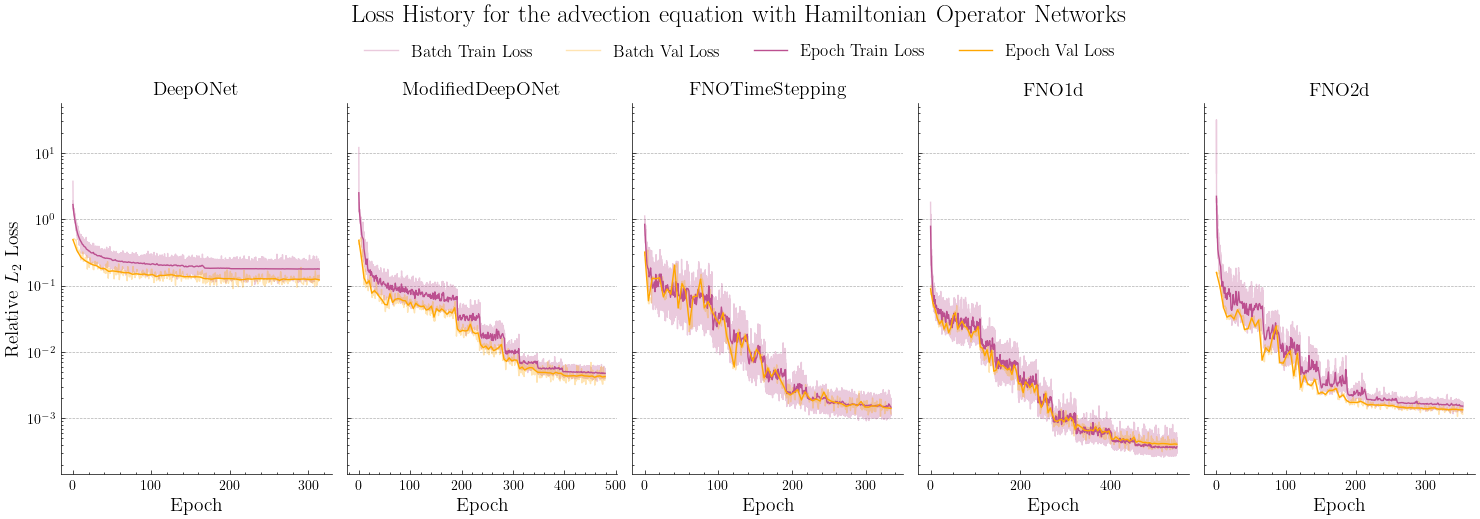

In [20]:
fig, axes = plt.subplots(1, len(u_preds_vanilla.keys()), figsize=(15, 5), sharey=True)
methods = list(hon_trainers.keys())
train_color = '#bc5090'
val_color = '#ffa600'

for i, (model_name, trainer) in enumerate(hon_trainers.items()):
        ax = axes[i]
        
        # Plot batch loss
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.train_loss_history_batch)),
                trainer.train_loss_history_batch, color=train_color, alpha=0.3, label='Batch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history_batch)),
                trainer.val_loss_history_batch, color=val_color, alpha=0.3, label='Batch Val Loss')
        
        # Plot epoch loss
        ax.plot(jnp.arange(len(trainer.train_loss_history)), trainer.train_loss_history, 
                color=train_color, label='Epoch Train Loss')
        ax.plot(jnp.linspace(0, trainer.epochs_trained - 1, len(trainer.val_loss_history)), 
                trainer.val_loss_history, 
                color=val_color, label='Epoch Val Loss')
        
        ax.set_title(pretty_names[model_name], fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_yscale('log')
        ax.tick_params(
                top=False,
                right=False, 
                which='both')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', which='major', linestyle='--', linewidth=0.5)
    
axes[0].set_ylabel(r'Relative $L_2$ Loss', fontsize=14)   

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.), fontsize='large')

fig.suptitle('Loss History for the advection equation with Hamiltonian Operator Networks', fontsize=18, x=0.5, y=1.05)
plt.tight_layout()
plt.savefig("loss/loss_hon_adv.svg")
plt.show()